# Clarificaciones
In the challenge, there is no investigation into the data due to a lack of knowledge about their behavior and meaning. For a proper Exploratory Data Analysis (EDA), a meeting should be held with the dataset owners.

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Libraries

In [112]:
import pandas as pd
import yaml
from sklearn.pipeline import Pipeline
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from src.data.make_dataset import get_Xs_ys, ReduceMemoryUsageTransformer
from src.preprocess.imputing import simple_imputer
from src.preprocess.encoding import one_hot_encoder, freq_encoder
from src.preprocess.feature_selection import pipe_feature_selection, save_selected_columns
from src.utils.utils import correlation_matrix, check_first_buy, class_weight


# Constants

In [101]:
URL = '/Users/sebastian/Proyects/meli_challenge/data/raw/sample_HVA_DS_Beauty.csv'

# Data

## Data Extraction

In [103]:
X_train, X_test, y_train, y_test = get_Xs_ys(**{'y_col': 'OBJETIVO',
                                                 'url': 'https://github.com/sebakirill/meli_challenge/raw/develop/data/sample_HVA_DS_Beauty.zip',
  'dst': '/Users/sebastian/Proyects/meli_challenge/data/sample_HVA_DS_Beauty.zip',
  'member_name': 'raw/sample_HVA_DS_Beauty.csv'})

In [116]:
X_train.select_dtypes('number').columns

Index(['TPV__SUM__MONEY_OUT__IOT__30', 'TPV__SUM__MONEY_IN__IOT__30',
       'TPN__COUNT__MONEY_OUT__IOT__30', 'QTY__SUM__ACT_DEVICES__MTS__30',
       'TPN__SUM__ON__MTS__30', 'TPV__SUM__OP_LINK_DOL__MTS__30',
       'TPV__SUM__OP_COW_API_DOL__MTS__30', 'TPV__SUM__ON_DOL__MTS__30',
       'FIRST_LOGIN_ML_YEARS__MAU__LK', 'LYL_TOTAL_VALID_POINTS__LYL__LK',
       ...
       'QTY__SUM__DOMAIN_AGG2__OFFICE_SCHOOLSUPPLIES__OAM__30',
       'QTY__SUM__DOMAIN_AGG2__REPLACEMENTAUTOPARTS__OAM__30',
       'SI__COUNT_DISTINCT__DOMAIN_AGG2__PERFUMERYHYGIENE__OAM__30',
       'NOTI__SUM__SHOWN__NOT__30', 'NOTI__SUM__OPEN__NOT__30',
       'NOTI__SUM__ARRIVED__NOT__30', 'NOTI__SUM__SENT__NOT__30',
       'AGE__KYC__LK', 'LEVEL__KYC__LK', 'CUST_ID'],
      dtype='object', length=184)

In [110]:
class_weight(url_files=['/Users/sebastian/Proyects/meli_challenge/conf/models/xgb_clas.yaml'], df=y_train)

In [109]:
config

{'name': 'XGBoost Classifier',
 'type': {'_target_': 'main.xgboost_mod',
  'colsample_bytree': {'high': 1.0, 'low': 0.6, 'q': 0.1},
  'learning_rate': {'high': 0.3, 'low': 0.01, 'q': 0.05},
  'max_depth': {'high': 10, 'low': 1, 'step': 1},
  'min_child_weight': {'high': 20, 'low': 1, 'step': 1},
  'min_samples_split': {'high': 1, 'low': 0.1, 'q': 0.1},
  'n_estimators': {'high': 600, 'low': 10, 'step': 10},
  'n_jobs': {'high': -1, 'low': -1, 'step': 0},
  'objective': 'binary:logitraw',
  'random_state': {'high': 123, 'low': 123, 'step': 0},
  'scale_pos_weight': {'high': 86.19, 'low': 86.19, 'step': 0},
  'subsample': {'high': 1.0, 'low': 0.6, 'q': 0.1}}}

### Check Fist Buy

Check if the customers buy beauty products for the first time.

In [8]:
check_first_buy(pd.concat([X_train, y_train], axis=1))

,OBJETIVO
CUST_ID,


In [9]:
check_first_buy(pd.concat([X_test, y_test], axis=1))

,OBJETIVO
CUST_ID,


## Feature Selection
Filter the important features using a simplified XGBoost model.

In [25]:
pipe_fe = pipe_feature_selection(objective='binary:logistic', enable_categorical=True, col=['SIT_SITE_ID', 'PHOTO_DATE'])

TypeError: pipe_feature_selection() missing 2 required positional arguments: 'imputation_num' and 'imputation_cat'

In [19]:
save_selected_columns(pipeline=pipe_fe.fit(X_train, y_train), url_file='/Users/sebastian/Proyects/meli_challenge/conf/data/reduce_memory_usage/reduce_memory_usage.yaml')

In [50]:
from xgboost import XGBClassifier
pipe_xgb = Pipeline([
    ('xgb', XGBClassifier(objective = "binary:logistic", scale_pos_weight=200000/2294))
])

In [89]:
pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 Pipeline(steps=[('red_mem', ReduceMemoryUsageTransformer()),
                                 ('encod',
                                  Pipeline(steps=[('freq_encoder',
                                                   FrequencyEncoder())])),
                                 ('simp',
                                  Pipeline(steps=[('imp_cat',
                                                   CategoricalImputer()),
                                                  ('imp_num',
                                                   MeanMedianImputer())]))])),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [92]:
xgb_df = pd.DataFrame(dict(xgb = pipe_xgb.named_steps['xgb'].feature_importances_), index=pipe_xgb.named_steps['xgb'].feature_names_in_)
xgb_df.sort_values(by='xgb', ascending=False).loc[xgb_df.xgb>0]

,xgb
ORDERS__SUM__BUY_ALL__ORD__30,0.097718
LYL_TOTAL_VALID_POINTS__LYL__LK,0.029310
ORDERS__SUM__MOB_BUY_ALL__ORD__30,0.022451
LYL_PURCHASE_VALID_POINTS__LYL__LK,0.019864
REC__MAX__BUY_ALL__ORD__30,0.018105
...,...
TPV__SUM__OP_LINK_DOL__MTS__30,0.002147
TRACKS__SUM__DESK_SEARCH_ML__TRK__30,0.001963
HITS__SUM__DOMAIN_AGG2__ELECTRICAL__OAM__30,0.001873
HITS__SUM__DOMAIN_AGG2__FOOTBALL__OAM__30,0.001765


In [95]:
pipe_imp.fit_transform(X_train).loc[:,xgb_df.loc[xgb_df.xgb>0].index]

,TPV__SUM__MONEY_OUT__IOT__30,TPV__SUM__MONEY_IN__IOT__30,TPN__COUNT__MONEY_OUT__IOT__30,QTY__SUM__ACT_DEVICES__MTS__30,TPN__SUM__ON__MTS__30,TPV__SUM__OP_LINK_DOL__MTS__30,TPV__SUM__ON_DOL__MTS__30,LYL_TOTAL_VALID_POINTS__LYL__LK,LYL_PURCHASE_VALID_POINTS__LYL__LK,LOGIN_DAYS_ML__MAU__LK,...,NOTI__SUM__ARRIVED__NOT__30,NOTI__SUM__SENT__NOT__30,AGE__KYC__LK,LEVEL__KYC__LK,CUST_ID,SEGMENT__MCH__LK_encoded,DEVICE_OPERATING_SYSTEM__PROFILE__LK_encoded,KNOWLEDGE__KYC__LK_encoded,ENTITY__KYC__LK_encoded,ADDR_STATE__KYC__LK_encoded
197035,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.0,1490.0,1435.0,14.0,...,0.0,0.0,28.0,6.0,6881914,0.347856,0.187254,0.652502,0.856873,0.031456
2736,177.850006,503.619995,7.0,0.0,0.0,5.089369,0.0,4237.0,3733.0,29.0,...,90.0,90.0,38.0,6.0,7458290,0.347856,0.812746,0.652502,0.856873,0.017615
18690,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.0,109.0,19.0,8.0,...,0.0,0.0,62.0,0.0,5306374,0.069486,0.812746,0.221697,0.856873,0.321533
87059,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.0,227.0,150.0,8.0,...,0.0,0.0,23.0,6.0,6916406,Missing,0.812746,0.652502,0.856873,0.007648
169575,255.000000,826.000000,9.0,0.0,0.0,0.000000,0.0,545.0,32.0,5.0,...,16.0,29.0,36.0,6.0,280084,0.340822,0.812746,0.652502,0.856873,0.057485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131292,355.000000,0.000000,3.0,0.0,0.0,0.000000,0.0,585.0,16.0,4.0,...,10.0,43.0,37.0,6.0,8696461,0.347856,0.812746,0.652502,0.856873,0.017073
52383,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.0,33.0,23.0,8.0,...,34.0,34.0,34.0,6.0,9176626,0.347856,0.812746,0.652502,0.856873,0.056613
175862,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.0,237.0,122.0,8.0,...,1.0,12.0,36.0,6.0,8658046,0.177395,0.812746,0.652502,0.856873,Missing
69314,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.0,194.0,129.0,10.0,...,33.0,38.0,27.0,6.0,7168411,0.177395,Missing,0.652502,0.856873,Missing


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import optuna
from omegaconf import DictConfig
import hydra
from hydra.utils import to_absolute_path

In [10]:
@hydra.main(config_name='config', config_path='conf', version_base='1.1')
def extract_data(cfg: DictConfig):
    X_train, X_test, y_train, y_test = hydra.utils.call(cfg.preprocess.type)
    return X_train

In [11]:
extract_data()

usage: ipykernel_launcher.py [--help] [--hydra-help] [--version]
                             [--cfg {job,hydra,all}] [--resolve]
                             [--package PACKAGE] [--run] [--multirun]
                             [--shell-completion] [--config-path CONFIG_PATH]
                             [--config-name CONFIG_NAME]
                             [--config-dir CONFIG_DIR]
                             [--experimental-rerun EXPERIMENTAL_RERUN]
                             [--info [{all,config,defaults,defaults-tree,plugins,searchpath}]]
                             [overrides ...]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/sebastian/Library/Jupyter/runtime/kernel-v2-1013oBptM0i6Pt5s.json


SystemExit: 2

/Users/sebastian/miniconda3/envs/wine_quality/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [7]:
from src.data.make_dataset import get_Xs_ys, ReduceMemoryUsageTransformer
from src.features.build_features import CreateNewFeaturesTransformer

In [7]:
URL = '/Users/sebastian/Proyects/wine_quality/data/raw/winequality-red.csv'

In [8]:
X_train, X_test, y_train, y_test = get_Xs_ys(URL, 'quality')

In [9]:
feature_engineering = Pipeline([
    ('reduce_memory', ReduceMemoryUsageTransformer()),
    ('new_features', CreateNewFeaturesTransformer())
])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2807
[LightGBM] [Info] Number of data points in the train set: 1279, number of used features: 19
[LightGBM] [Info] Start training from score -5.074392
[LightGBM] [Info] Start training from score -3.416164
[LightGBM] [Info] Start training from score -0.853048
[LightGBM] [Info] Start training from score -0.919423
[LightGBM] [Info] Start training from score -2.084930
[LightGBM] [Info] Start training from score -4.445784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

0.68125

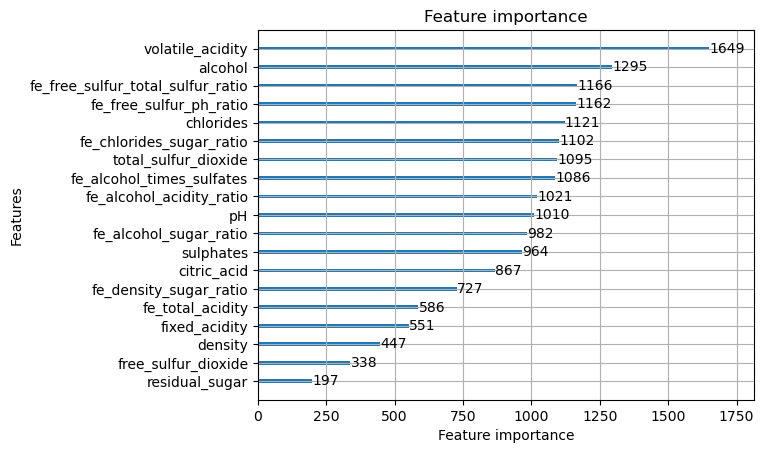

In [15]:
lgb = LGBMClassifier(objective = "multiclass")
lgb.fit(feature_engineering.fit_transform(X_train, y_train), y_train)
accuracy_score(y_test, lgb.predict(feature_engineering.fit_transform(X_test, y_test)))

/Users/sebastian/miniconda3/envs/wine_quality/lib/python3.12/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/sebastian/miniconda3/envs/wine_quality/lib/python3.12/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/sebastian/miniconda3/envs/wine_quality/lib/python3.12/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/sebastian/miniconda3/envs/wine_quality/lib/python3.12/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. U

0.6875

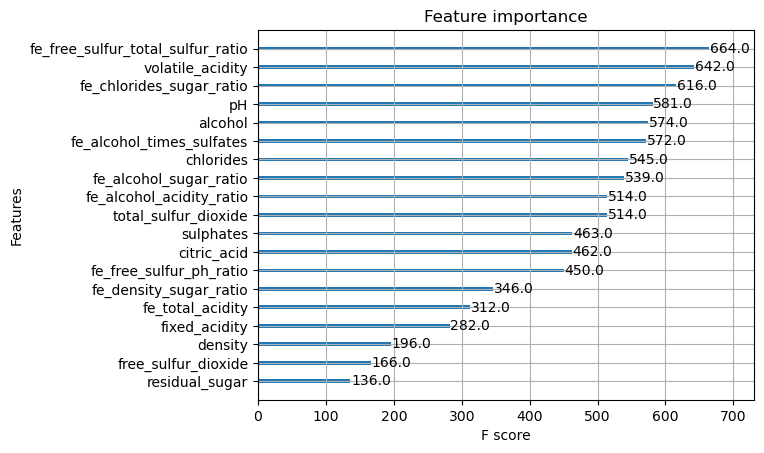

In [17]:
xgb = XGBClassifier(objective = "binary:logistic")
xgb.fit(feature_engineering.fit_transform(X_train, y_train), y_train)
accuracy_score(y_test, xgb.predict(feature_engineering.fit_transform(X_test, y_test)))

In [22]:

lgb_importances = pd.DataFrame(dict(lgbm = lgb.feature_importances_), index=lgb.feature_name_)
xgb_importances = pd.DataFrame(dict(xgb = xgb.feature_importances_), index=xgb.feature_names_in_)
importances = pd.concat([lgb_importances,xgb_importances],axis=1)
min_max = MinMaxScaler(feature_range=(1,1.1))
importances["cross"] = min_max.fit_transform(importances[["lgbm"]]) * min_max.fit_transform(importances[["xgb"]])
sorted = importances.sort_values(by="cross", ascending=False)
sorted

,lgbm,xgb,cross
alcohol,1295,0.148553,1.183182
volatile_acidity,1649,0.064618,1.128603
sulphates,964,0.076070,1.090829
total_sulfur_dioxide,1095,0.061440,1.086481
fe_free_sulfur_total_sulfur_ratio,1166,0.043780,1.074877
fe_alcohol_times_sulfates,1086,0.048434,1.073679
fe_chlorides_sugar_ratio,1102,0.045227,1.071790
fe_free_sulfur_ph_ratio,1162,0.039807,1.070863
chlorides,1121,0.038507,1.066809
pH,1010,0.046019,1.066135


In [25]:
def objective_xg(trial):
    """Define the objective function"""

    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.3, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        "seed" : trial.suggest_categorical('seed', [42]),
        'objective': trial.suggest_categorical('objective', ['multi:softmax']),
    }
    model_xgb = XGBClassifier(**params)
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)
    return accuracy_score(y_test,y_pred)

In [27]:
study_xgb = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb.optimize(objective_xg, n_trials=50,show_progress_bar=True)

[I 2023-12-09 08:16:44,227] A new study created in memory with name: no-name-9feb6148-42c0-4ff4-b277-d1c94a32475a
  0%|          | 0/50 [00:00<?, ?it/s]/var/folders/2c/3dzcy1r97qqf84vj6j5nvf6m0000gn/T/ipykernel_35090/1875206445.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
/var/folders/2c/3dzcy1r97qqf84vj6j5nvf6m0000gn/T/ipykernel_35090/1875206445.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
/var/folders/2c/3dzcy1r97qqf84vj6j5nvf6m0000gn/T/ipykernel_35090/1875206445.py:11: FutureWarning: suggest_loguniform has been deprecated in v3

In [28]:
xgb = XGBClassifier(**study_xgb.best_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)



/Users/sebastian/miniconda3/envs/wine_quality/lib/python3.12/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/sebastian/miniconda3/envs/wine_quality/lib/python3.12/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/sebastian/miniconda3/envs/wine_quality/lib/python3.12/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/sebastian/miniconda3/envs/wine_quality/lib/python3.12/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. U

Accuracy:  0.684375


/Users/sebastian/miniconda3/envs/wine_quality/lib/python3.12/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/sebastian/miniconda3/envs/wine_quality/lib/python3.12/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/sebastian/miniconda3/envs/wine_quality/lib/python3.12/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/sebastian/miniconda3/envs/wine_quality/lib/python3.12/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. U